# **Use Python to analyze the sloshing in the fuel tank**

A program is developed to calculate the sloshing mode, frequency, and the corresponding mechanical analogy (pendulum or spring) based on the profile of the fuel tank. The fuel tank can be **ANY** body of revolution. The code is completely based on the work of the [LGST-LAB](https://github.com/LGST-LAB/slosh_ml), which is implemented by MATLAB. We implement our code in Python for possible later machine learning tasks. 

The calculation is mainly based on the irrotational-incompressible flow theory and the Rayleigh-Ritz method. We first compute the mode of the potential function of the fluid in the tank by Rayleigh-Ritz method and the governing Laplace equation. Then the mechanical analogy is generated which can reproduce the response of the fluid. More review on the mathematical background of this method can be found at [this site](https://www.researchgate.net/publication/377851094_Open-Source_Propellant_Sloshing_Modeling_and_Simulation).

The program is developed by Chenyu Wu, during the internship in Orienspace, 2024.

## **The basic usage of the program**
We load the `Tank` class from the source file. The `Tank` object should be instantiated by a text file that contains the coordinate of the inner profile and the outer profile of a fuel tank. In this text file, the first two colums are the $z, r$ coordinate of the inner profile, and the last two colums are the $z, r$ coordinate of the outer profile. All missing values can be filled by `NaN`. Use the `delimiter` argument to specify the delimiter used in the text file.

The physical and numerical settings is input by the `settings.txt` file. The definition of each input paramter is shown in the table:
| **Name**       | N                                                      | M                                                                           | nsteps                                                                  | nmodes                                  | SpringModeSpinner                  | g                             | rho                      |
|----------------|--------------------------------------------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------|-----------------------------------------|------------------------------------|-------------------------------|--------------------------|
| **Definition** | The number of eigen functions to approximate each mode | The number of shallow tank functions in the whole family of eigen functions | The number of cells in each direction to approximate the 2D integration | The number of modes we are interest in. | The number of springs or pendulums | Acceleration, in -z direction | The density of the fluid |

The `LFR` argument is defined as:
$$
\text{LFR} = H_{fluid} / H_{tank}
$$
$H_{fluid}$ is the depth of the fluid and $H_{tank}$ is the height of the fuel tank. `LFR` should be strictly within $(0,1)$.

In [1]:
from Slosh import Tank

Here we load the tank of the Saturn-V rocket. After loading the tank, we show the geometry. The blue line is the surface of the fluid at rest. The green cross is the center of mass of the fluid. It is always located at the origin.

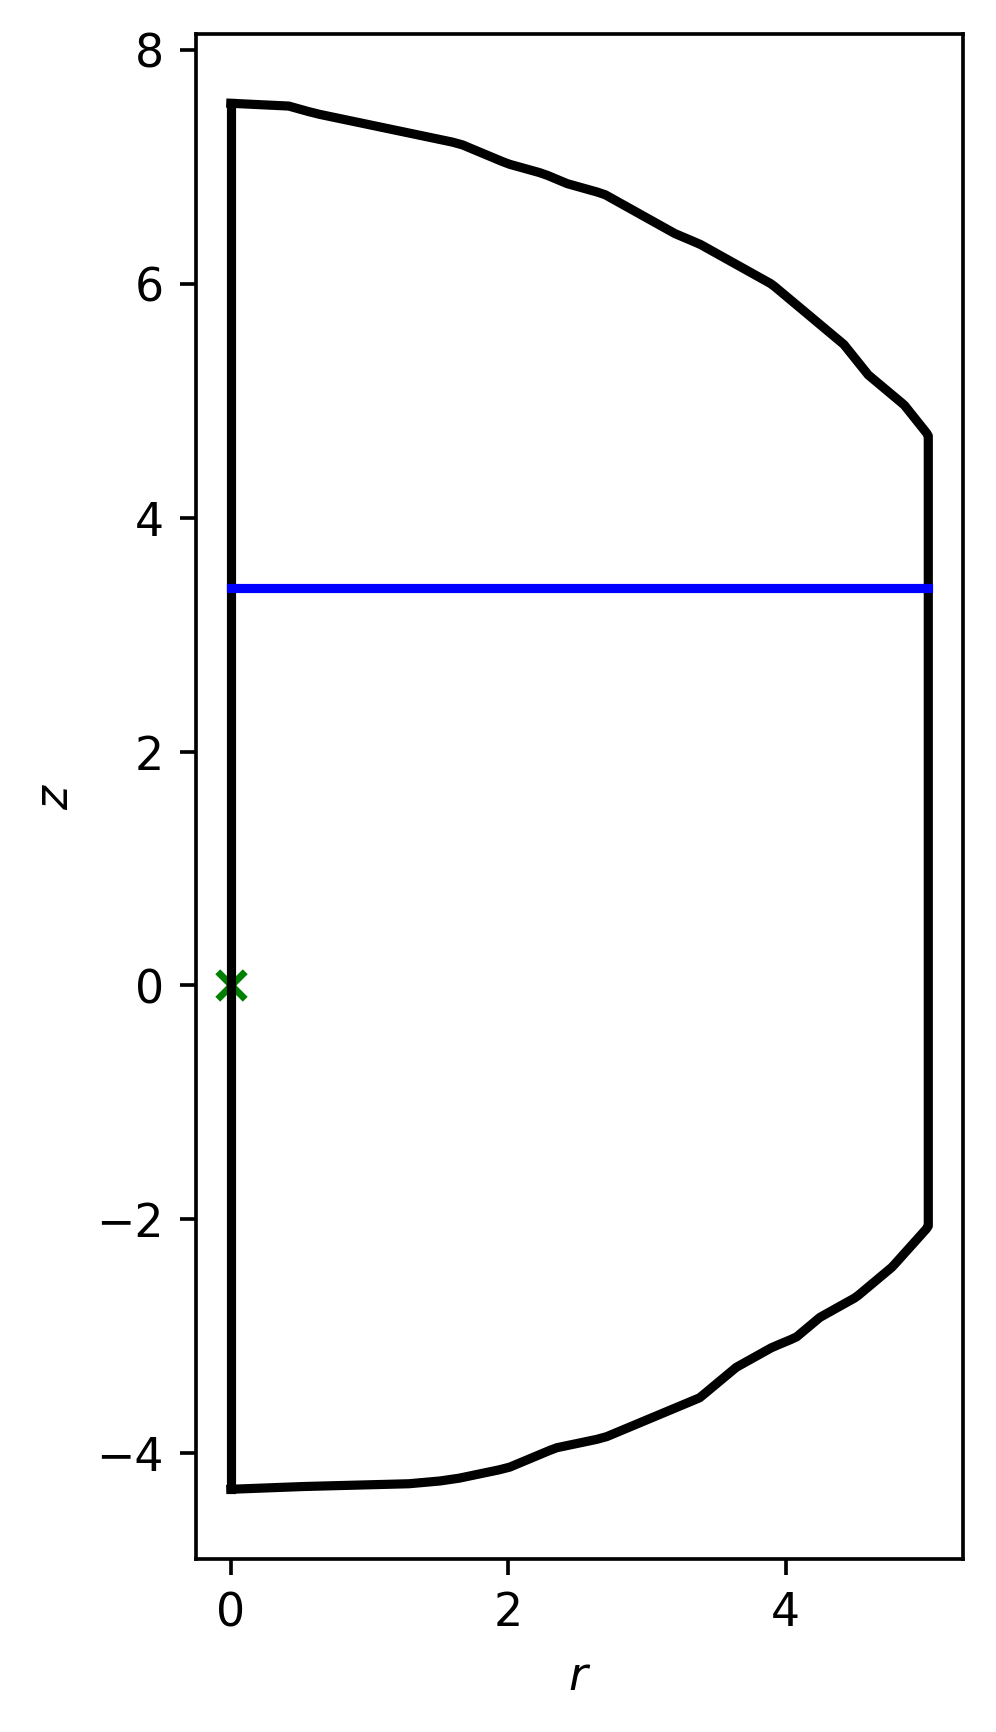

In [2]:
tank = Tank(LFR = 0.65, fname = "RP1_Tank_SaturnV.txt", delimiter=",", settings="settings.txt")
tank.plot_geo()

Analyze the tank by simply calling `tank.calculate()` function. It will compute the coefficient for each eigen function of each mode, the frequency, and the mechanical analogies.

In [3]:
tank.calculate()

100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


By calling the `tank.report()` function, we can show the data of the mechanical analogies using `pandas`. The parameters of the pendulum, the springs, and the corresponding frequencies for each mode are output sequentially.

By calling the `tank.plot_springs()` function, we can plot the analogous spring in the fuel tank. By calling the `tank.plot_modes()` function, we can plot the surface shape of each mode.

In [4]:
tank.report()

,Mass,Length,Height,CM
Fixed mass,347013.803406,0.000000,4.877075,0.000000
1,179106.195119,2.761719,5.907723,1.524046
2,5445.577755,0.943310,6.774268,0.388640
3,1298.832187,0.589152,7.115642,0.237551


,Mass,Height,K
Fixed mass,347013.803406,4.877075,inf
1,179106.195119,3.146005,6.362095e+05
2,5445.577755,5.830958,5.663155e+04
3,1298.832187,6.526489,2.162690e+04


,0,1,2,3,4,5,6,7,8,9
lambda,1.821040,5.331439,8.536330,11.706072,1301.097440,14.863809,6001.758214,1.066463e+07,7.006104e+12,-5.656453e+13
K,1.229471,3.599509,5.763285,7.903329,878.433113,10.035269,4052.074034,7.200205e+06,4.730156e+12,-3.818942e+13
Omega,1.884711,3.224833,4.080568,4.778490,50.377889,5.384559,108.199262,4.560979e+03,3.696778e+06,1.050406e+07


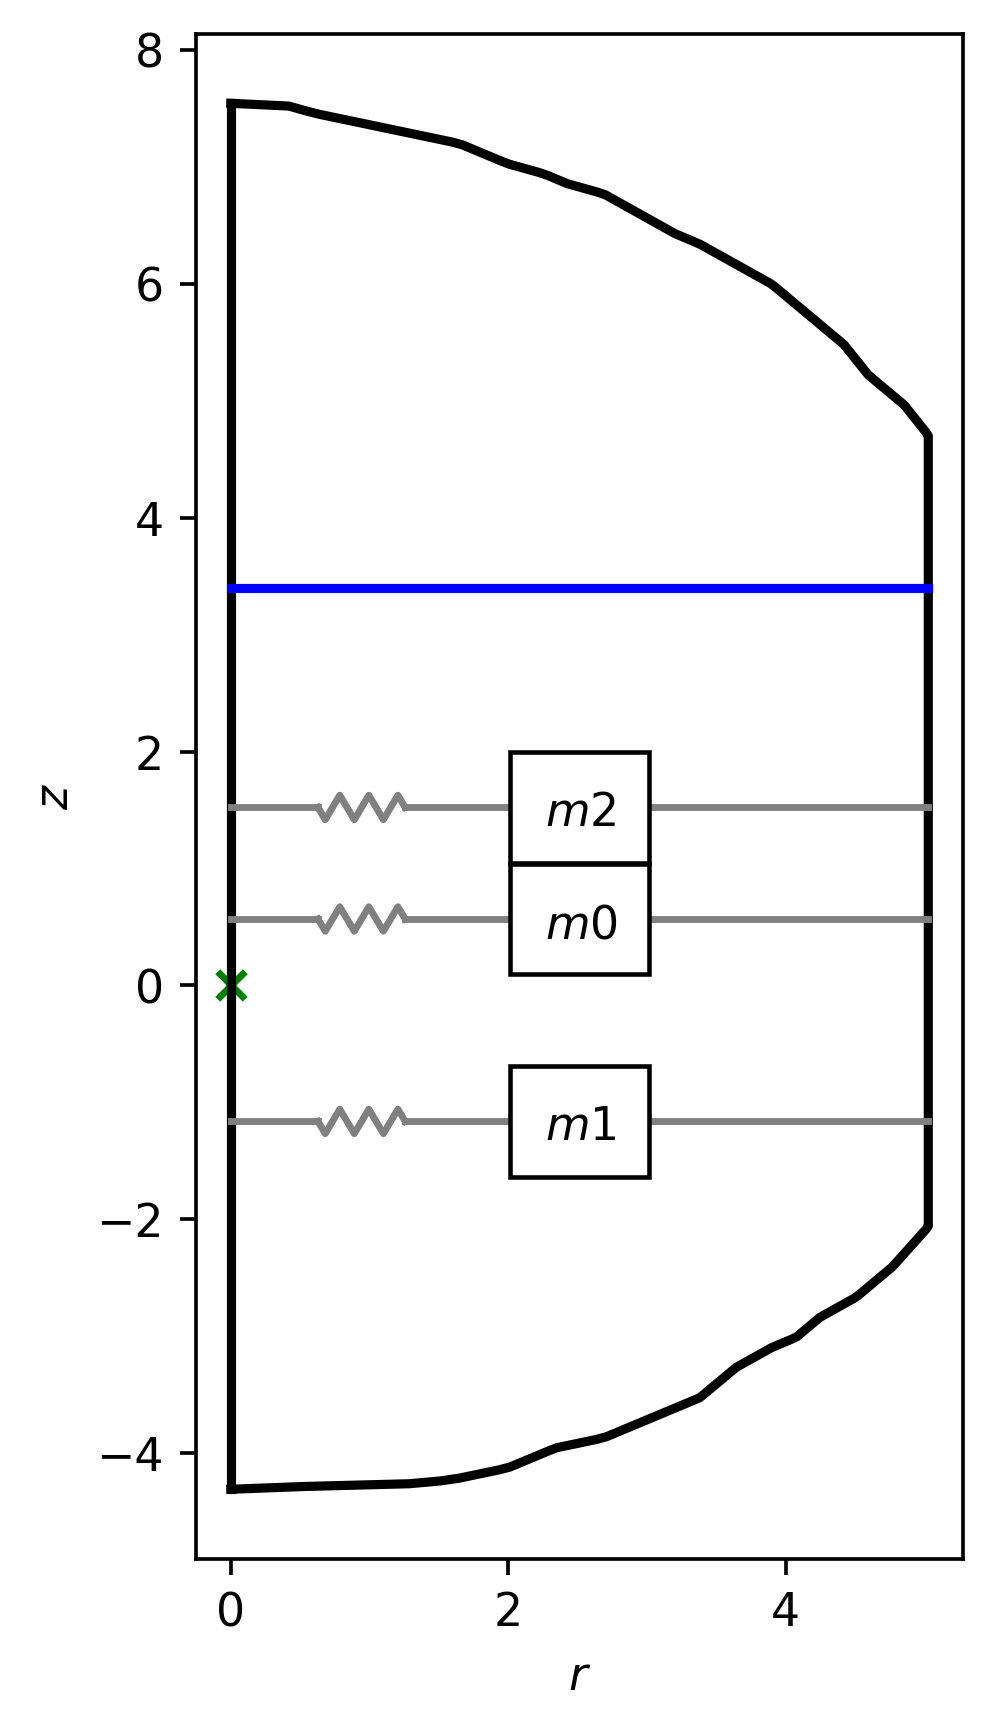

In [5]:
tank.plot_springs()

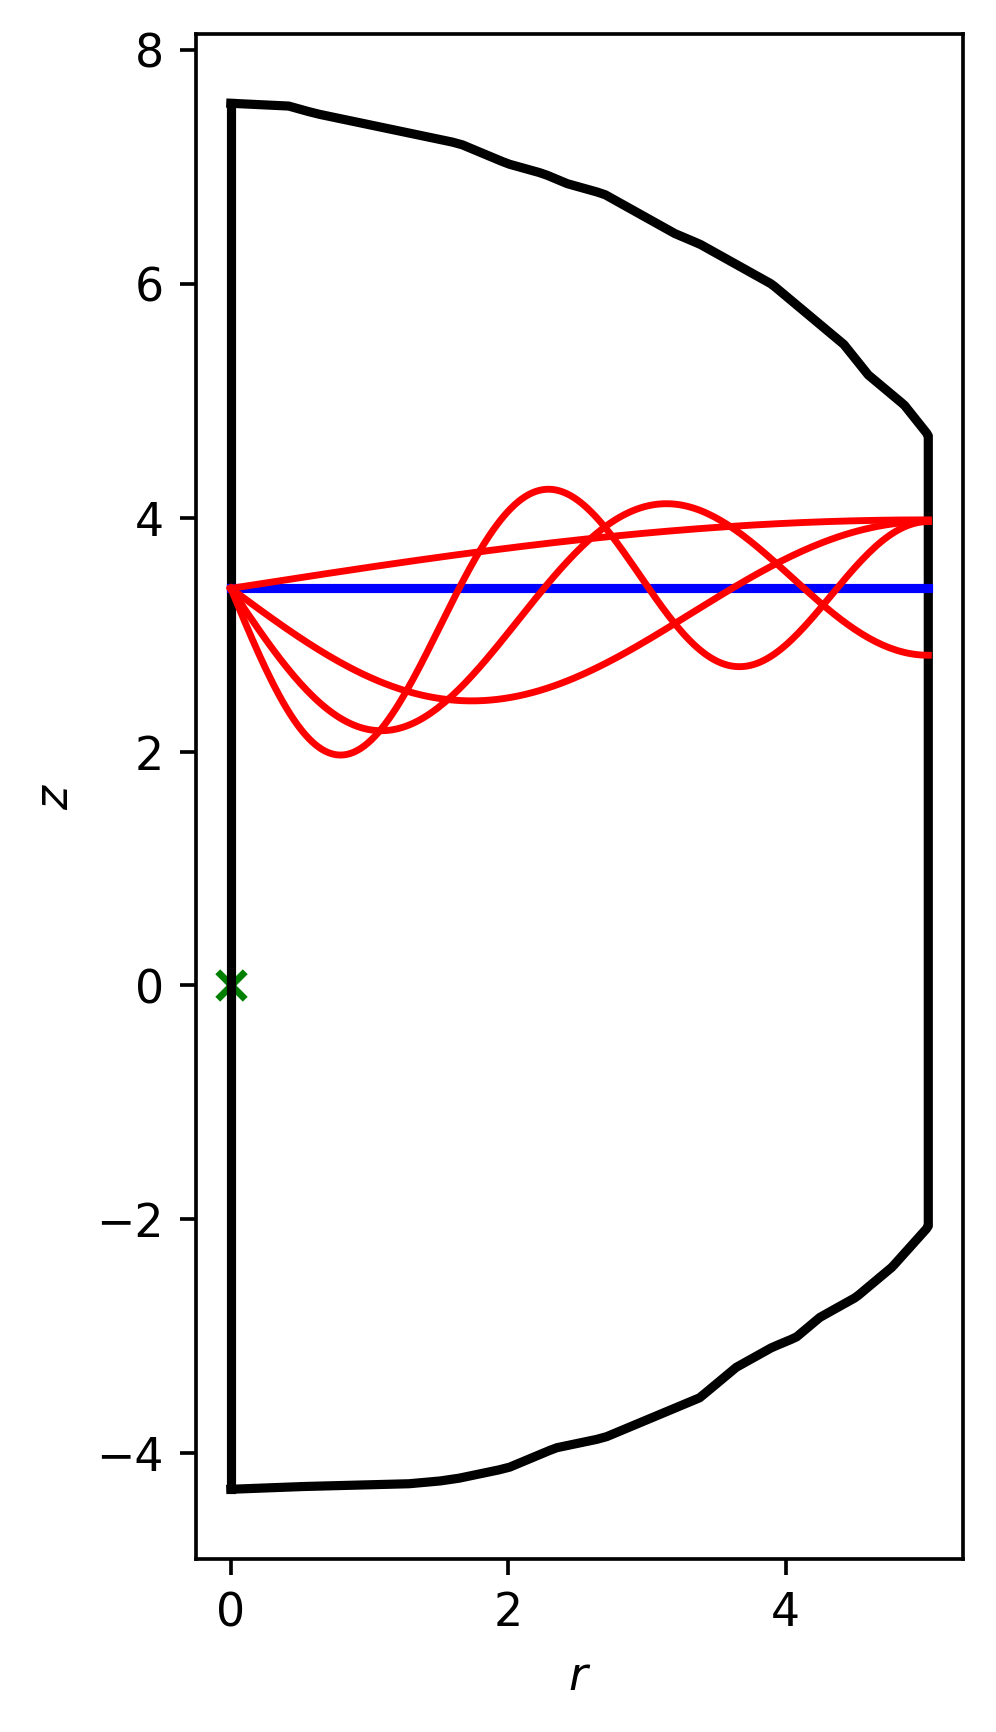

In [6]:
tank.plot_modes(normalize=False, nmodes = 4)

## **Use the program to output a list of mechanical properties along the whole flight**
During the actual flight of the rocket, the LFR and the acceleration are varyiny constantly. To analyze the lateral sloshing of the fluid during the whole flight, a list of parameters must be output. However, only the LFR will affect the eigen value problem. So for a fixed LFR, we only solve the eigen value problem for once, and then we vary the acceleration to get a list of parameters under this specific LFR.

In [2]:
import numpy as np
from Slosh import Tank
from tqdm import tqdm

In [4]:
nLFR = 91
N = 10

LFRs = np.linspace(0.10, 0.95, nLFR)
M_ks = np.full((nLFR, N), fill_value=np.nan)
L_ks = np.full((nLFR, N), fill_value=np.nan)
H_ks = np.full((nLFR, N), fill_value=np.nan)

M_0s = np.full(nLFR, fill_value=np.nan)
H_0s = np.full(nLFR, fill_value=np.nan)

i = 0
for i in tqdm(range(nLFR)):
    tank = Tank(LFRs[i], fname="RP1_Tank_SaturnV.txt", delimiter=",", settings="settings.txt")
    tank.calculate(comupute_analogies=True)
    M_k, L_k, H_k = tank.output_analogy_params()

    M_ks[i, :] = M_k[1:]
    L_ks[i, :] = L_k[1:]
    H_ks[i, :] = H_k[1:]

    M_0s[i], H_0s[i] = M_k[0], H_k[0]


100%|██████████| 91/91 [03:54<00:00,  2.58s/it]


In [5]:
np.save("./Dataset/M_k", M_ks)
np.save("./Dataset/H_k", H_ks)
np.save("./Dataset/L_k", L_ks)
np.save("./Dataset/M_0", M_0s)
np.save("./Dataset/H_0", H_0s)

In [9]:
np.save("./Dataset/LFR", LFRs)

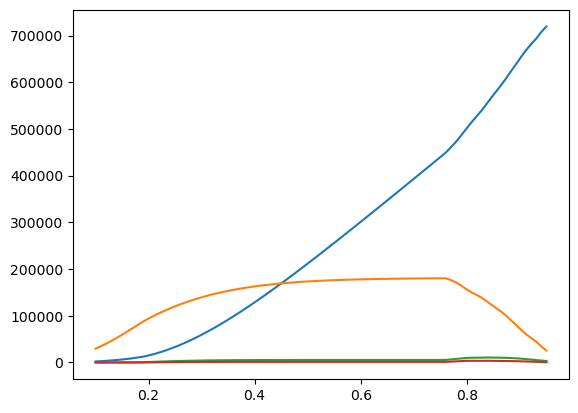

In [8]:
import matplotlib.pyplot as plt

plt.plot(LFRs, M_0s)
plt.plot(LFRs, M_ks[:, 0])
plt.plot(LFRs, M_ks[:, 1])
plt.plot(LFRs, M_ks[:, 2])